In [1]:
%pip install kaggle
%pip install opendatasets

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105797 sha256=c3ca4f3f16596df7a65ae58a0ff6a500efd020dc3f3173ddb625834a203de984
  Stored in directory: c:\users\acer\appdata\local\pip\cache\wheels\9f\af\22\bf406f913dc7506a485e60dce8143741abd0a92a19337d83a3
Successfully built kaggle
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install opendatasets pandas matplotlib numpy tensorflow


  Using cached tensorflow-2.17.0-cp310-cp310-win_amd64.whl.metadata (3.2 kB)
  Using cached tensorflow_intel-2.17.0-cp310-cp310-win_amd64.whl.metadata (5.0 kB)
Using cached tensorflow-2.17.0-cp310-cp310-win_amd64.whl (2.0 kB)
Using cached tensorflow_intel-2.17.0-cp310-cp310-win_amd64.whl (385.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import opendatasets as od
import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random

from os import listdir
import shutil
import numpy as np
import keras.preprocessing.image as kerasImg
import keras.layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import ops

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout



In [2]:
import os
import pandas as pd
from PIL import Image
import numpy as np

# Ruta a los directorios de imágenes
base_dir = "PolyMNIST/MMNIST"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

def load_images_from_folder(folder):
    images = []
    labels = []
    for modality in range(5):  # Para cada modalidad de m0 a m4
        modality_dir = os.path.join(folder, f"m{modality}")
        for filename in os.listdir(modality_dir):
            if filename.endswith(".png"):
                try:
                    # Cargar la imagen
                    img_path = os.path.join(modality_dir, filename)
                    img = Image.open(img_path)
                    img_array = np.array(img)
                    
                    # Extraer la etiqueta del nombre del archivo
                    label = filename.split('.')[1]  # Por ejemplo: 1.2.png -> 2
                    
                    images.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Error al cargar {filename}: {e}")
    return np.array(images), np.array(labels)

# Cargar las imágenes de entrenamiento y prueba
train_images, train_labels = load_images_from_folder(train_dir)
test_images, test_labels = load_images_from_folder(test_dir)

# Convertir a DataFrame para una visualización más fácil
train_df = pd.DataFrame({'image': list(train_images), 'label': train_labels})
test_df = pd.DataFrame({'image': list(test_images), 'label': test_labels})

print(train_df.head())


                                               image label
0  [[[202, 208, 234], [202, 208, 234], [200, 207,...     0
1  [[[34, 34, 24], [35, 35, 25], [35, 35, 25], [3...     1
2  [[[171, 186, 225], [171, 186, 225], [172, 187,...     2
3  [[[35, 29, 39], [42, 32, 41], [37, 25, 35], [3...     3
4  [[[204, 205, 210], [199, 200, 205], [199, 200,...     4


In [3]:
train_df.to_csv('train.csv', index=False)
train_df.to_csv('test.csv', index=False)

In [ ]:
# Get back the images and labels from the dataframe

# train_images = np.array(train_df['image'].tolist())
# train_labels = np.array(train_df['label'].tolist())

# test_images = np.array(test_df['image'].tolist())
# test_labels = np.array(test_df['label'].tolist())


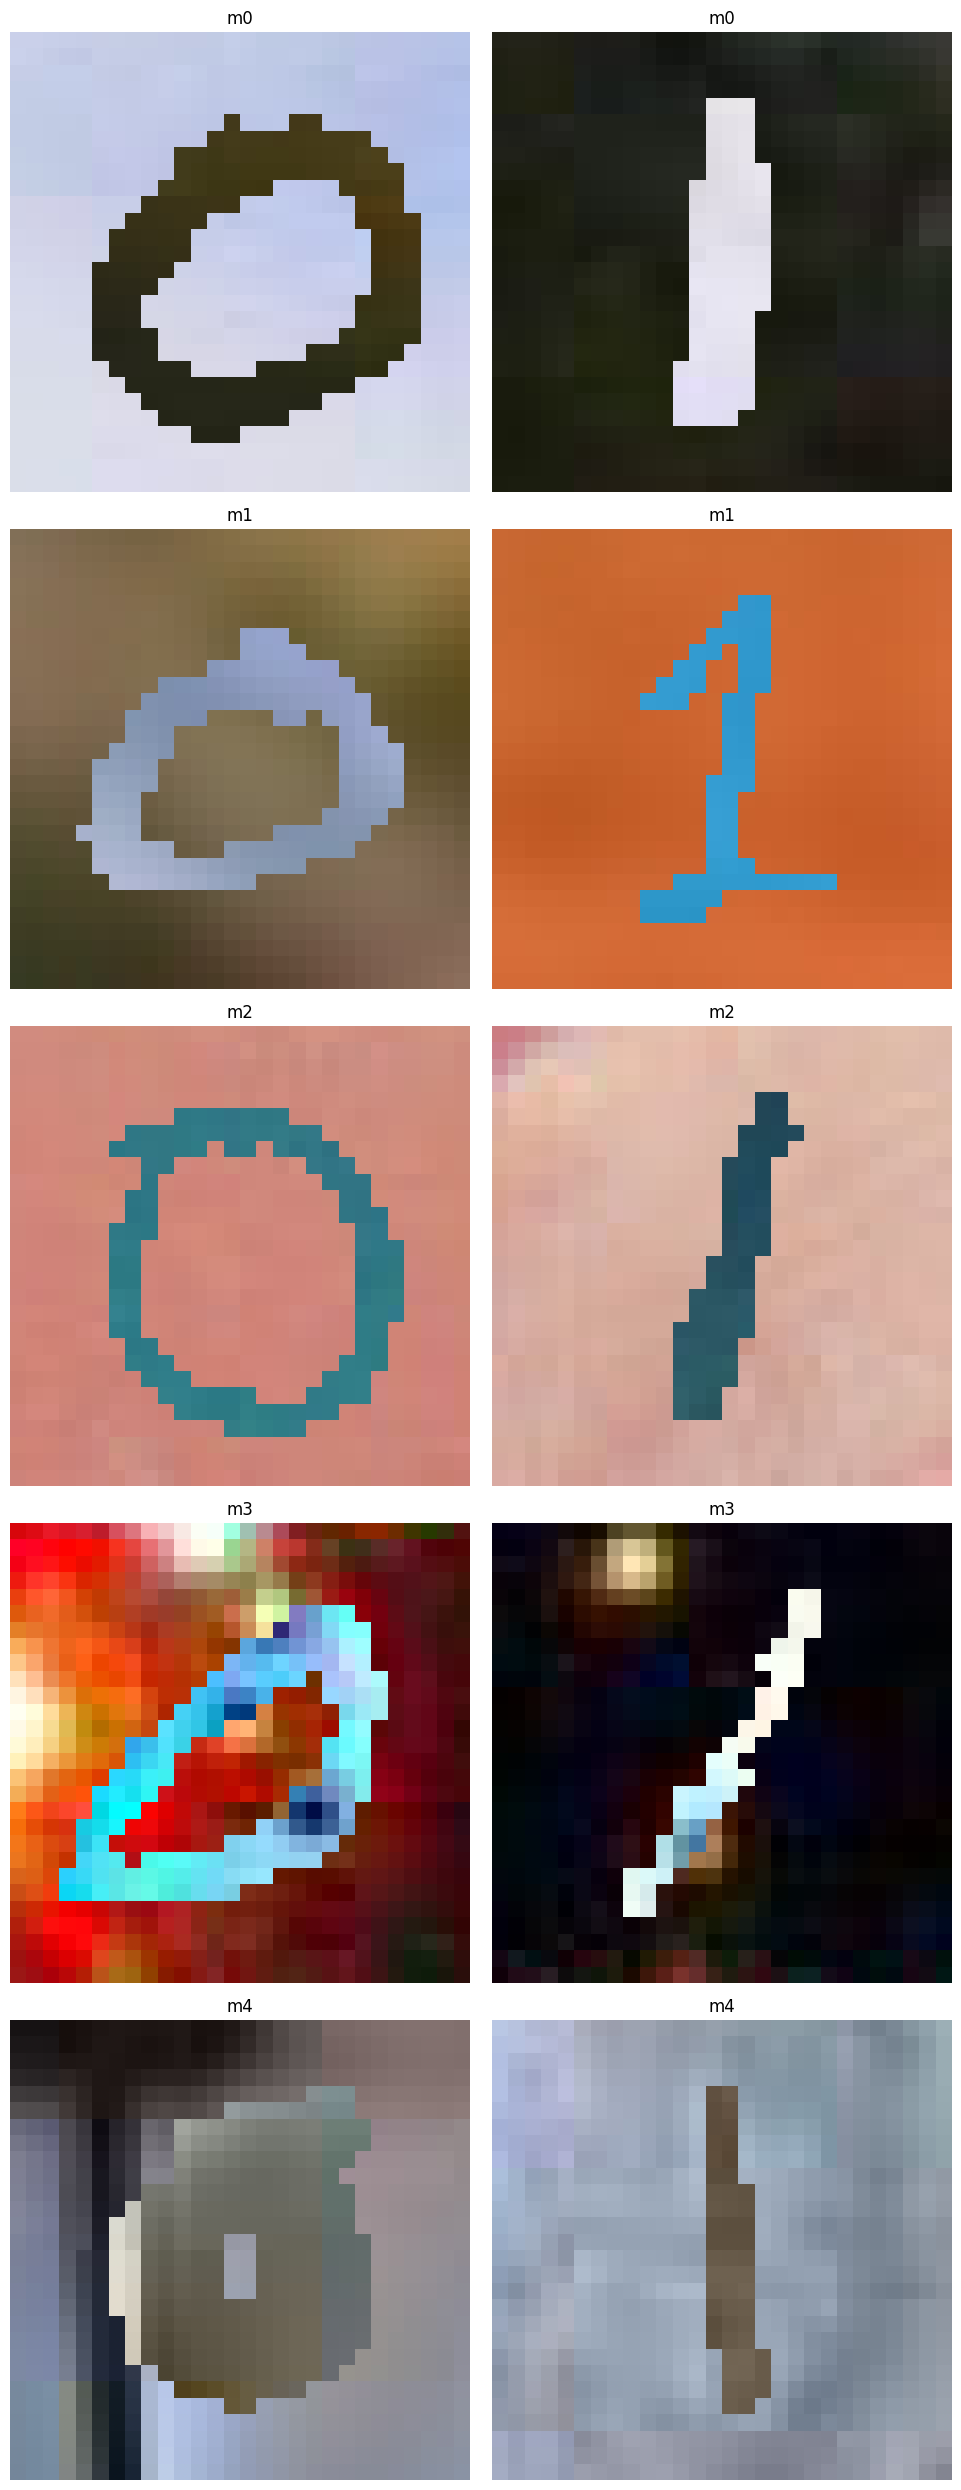

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Ruta a los directorios de imágenes
base_dir = "PolyMNIST/MMNIST"
train_dir = os.path.join(base_dir, "train")

def load_example_images(folder, modalities=[0, 1, 2, 3, 4], num_examples=2):
    images = {}
    for modality in modalities:
        modality_dir = os.path.join(folder, f"m{modality}")
        modality_images = []
        for filename in os.listdir(modality_dir):
            if filename.endswith(".png"):
                if len(modality_images) < num_examples:
                    img_path = os.path.join(modality_dir, filename)
                    img = Image.open(img_path)
                    modality_images.append(img)
                else:
                    break
        images[modality] = modality_images
    return images

# Cargar una o dos imágenes de cada modalidad
example_images = load_example_images(train_dir, num_examples=2)

def plot_example_images(example_images):
    num_modalities = len(example_images)
    num_examples = len(next(iter(example_images.values())))
    
    plt.figure(figsize=(10, 5 * num_modalities))
    
    for modality, imgs in example_images.items():
        for i, img in enumerate(imgs):
            plt.subplot(num_modalities, num_examples, modality * num_examples + i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"m{modality}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Mostrar una o dos imágenes de cada modalidad
plot_example_images(example_images)


In [12]:
def get_image_resolution(images):
    if len(images) > 0:
        # Asumiendo que todas las imágenes tienen la misma resolución
        return images[0].shape
    return None

# Obtener la resolución de las imágenes
train_resolution = get_image_resolution(train_images)
test_resolution = get_image_resolution(test_images)

print(f"Resolución de las imágenes en el conjunto de entrenamiento: {train_resolution}")
print(f"Resolución de las imágenes en el conjunto de prueba: {test_resolution}")


Resolución de las imágenes en el conjunto de entrenamiento: (28, 28, 3)
Resolución de las imágenes en el conjunto de prueba: (28, 28, 3)


In [13]:
def count_labels(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))

# Contar las etiquetas en los conjuntos de entrenamiento y prueba
train_label_counts = count_labels(train_labels)
test_label_counts = count_labels(test_labels)

print("Número de imágenes por etiqueta en el conjunto de entrenamiento:")
for label, count in train_label_counts.items():
    print(f"Etiqueta {label}: {count}")

print("\nNúmero de imágenes por etiqueta en el conjunto de prueba:")
for label, count in test_label_counts.items():
    print(f"Etiqueta {label}: {count}")

# Convertir los resultados a DataFrames para una visualización más clara
train_counts_df = pd.DataFrame(list(train_label_counts.items()), columns=['Etiqueta', 'Número de Imágenes'])
test_counts_df = pd.DataFrame(list(test_label_counts.items()), columns=['Etiqueta', 'Número de Imágenes'])

print("\nDistribución en el conjunto de entrenamiento:")
print(train_counts_df)

print("\nDistribución en el conjunto de prueba:")
print(test_counts_df)


Número de imágenes por etiqueta en el conjunto de entrenamiento:
Etiqueta 0: 50
Etiqueta 1: 50
Etiqueta 10: 50
Etiqueta 100: 50
Etiqueta 1000: 50
Etiqueta 1001: 50
Etiqueta 1002: 50
Etiqueta 1003: 50
Etiqueta 1004: 50
Etiqueta 1005: 50
Etiqueta 1006: 50
Etiqueta 1007: 50
Etiqueta 1008: 50
Etiqueta 1009: 50
Etiqueta 101: 50
Etiqueta 1010: 50
Etiqueta 1011: 50
Etiqueta 1012: 50
Etiqueta 1013: 50
Etiqueta 1014: 50
Etiqueta 1015: 50
Etiqueta 1016: 50
Etiqueta 1017: 50
Etiqueta 1018: 50
Etiqueta 1019: 50
Etiqueta 102: 50
Etiqueta 1020: 50
Etiqueta 1021: 50
Etiqueta 1022: 50
Etiqueta 1023: 50
Etiqueta 1024: 50
Etiqueta 1025: 50
Etiqueta 1026: 50
Etiqueta 1027: 50
Etiqueta 1028: 50
Etiqueta 1029: 50
Etiqueta 103: 50
Etiqueta 1030: 50
Etiqueta 1031: 50
Etiqueta 1032: 50
Etiqueta 1033: 50
Etiqueta 1034: 50
Etiqueta 1035: 50
Etiqueta 1036: 50
Etiqueta 1037: 50
Etiqueta 1038: 50
Etiqueta 1039: 50
Etiqueta 104: 50
Etiqueta 1040: 50
Etiqueta 1041: 50
Etiqueta 1042: 50
Etiqueta 1043: 50
Etiqueta 104

In [16]:
import matplotlib.pyplot as plt

def check_balance(label_counts):
    total_images = sum(label_counts.values())
    num_classes = len(label_counts)
    balanced = True
    threshold = 0.2  # Umbral de desequilibrio permitido

    print(f"Total de imágenes: {total_images}")
    print(f"Número de clases: {num_classes}")
    
    for label, count in label_counts.items():
        proportion = count / total_images
        print(f"Etiqueta {label}: {count} imágenes ({proportion:.2%})")
        # Verificar si la clase tiene menos del umbral de desequilibrio permitido
        if proportion < 1 / num_classes - threshold or proportion > 1 / num_classes + threshold:
            balanced = False
    
    return balanced

# Verificar el balanceo en el conjunto de entrenamiento y prueba
train_balance = check_balance(train_label_counts)
test_balance = check_balance(test_label_counts)

if train_balance:
    print("\nEl conjunto de entrenamiento está balanceado.")
else:
    print("\nEl conjunto de entrenamiento NO está balanceado.")

if test_balance:
    print("\nEl conjunto de prueba está balanceado.")
else:
    print("\nEl conjunto de prueba NO está balanceado.")


Total de imágenes: 300000
Número de clases: 6742
Etiqueta 0: 50 imágenes (0.02%)
Etiqueta 1: 50 imágenes (0.02%)
Etiqueta 10: 50 imágenes (0.02%)
Etiqueta 100: 50 imágenes (0.02%)
Etiqueta 1000: 50 imágenes (0.02%)
Etiqueta 1001: 50 imágenes (0.02%)
Etiqueta 1002: 50 imágenes (0.02%)
Etiqueta 1003: 50 imágenes (0.02%)
Etiqueta 1004: 50 imágenes (0.02%)
Etiqueta 1005: 50 imágenes (0.02%)
Etiqueta 1006: 50 imágenes (0.02%)
Etiqueta 1007: 50 imágenes (0.02%)
Etiqueta 1008: 50 imágenes (0.02%)
Etiqueta 1009: 50 imágenes (0.02%)
Etiqueta 101: 50 imágenes (0.02%)
Etiqueta 1010: 50 imágenes (0.02%)
Etiqueta 1011: 50 imágenes (0.02%)
Etiqueta 1012: 50 imágenes (0.02%)
Etiqueta 1013: 50 imágenes (0.02%)
Etiqueta 1014: 50 imágenes (0.02%)
Etiqueta 1015: 50 imágenes (0.02%)
Etiqueta 1016: 50 imágenes (0.02%)
Etiqueta 1017: 50 imágenes (0.02%)
Etiqueta 1018: 50 imágenes (0.02%)
Etiqueta 1019: 50 imágenes (0.02%)
Etiqueta 102: 50 imágenes (0.02%)
Etiqueta 1020: 50 imágenes (0.02%)
Etiqueta 1021: 50

### Parte 3

In [4]:
def preprocess_data(images, labels):
    images = images.astype('float32') / 255.0
    labels = to_categorical(labels, num_classes=10)
    images = images.reshape(images.shape[0], 28, 28, 3)
    return images, labels


# Process the training data
X_train, y_train = preprocess_data(train_images, train_labels)

# Process the test data
X_test, y_test = preprocess_data(test_images, test_labels)


In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape 

((300000, 28, 28, 3), (300000, 10), (50000, 28, 28, 3), (50000, 10))

In [6]:
def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_model()
cnn_model.summary()

def create_mlp_model():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 3)))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mlp_model = create_mlp_model()
mlp_model.summary()


C:\Users\rentt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,610 (881.29 KB)

 Trainable params: 225,610 (881.29 KB)

 Non-trainable params: 0 (0.00 B)

C:\Users\rentt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,204,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,472,522 (5.62 MB)

 Trainable params: 1,472,522 (5.62 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Por motivos de tiempo, vamos a reducir el tamaño del conjunto de datos

X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42)
X_test_small, _, y_test_small, _ = train_test_split(X_test, y_test, test_size=0.1, random_state=42)


In [8]:
X_train_small.shape, y_train_small.shape, X_test_small.shape, y_test_small.shape 

((30000, 28, 28, 3), (30000, 10), (45000, 28, 28, 3), (45000, 10))

In [10]:
cnn_history = cnn_model.fit(X_train_small, y_train_small, validation_data=(X_test_small, y_test_small), epochs=10, batch_size=128, verbose=2)
mlp_history = mlp_model.fit(X_train_small, y_train_small, validation_data=(X_test_small, y_test_small), epochs=10, batch_size=128, verbose=2)

## Esto será con toda la data
# cnn_history = cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4, batch_size=128, verbose=2)
# mlp_history = mlp_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4, batch_size=128, verbose=2)


Epoch 1/10
235/235 - 5s - 20ms/step - accuracy: 0.9397 - loss: 0.1944 - val_accuracy: 0.9521 - val_loss: 0.1531
Epoch 2/10
235/235 - 5s - 23ms/step - accuracy: 0.9466 - loss: 0.1667 - val_accuracy: 0.9570 - val_loss: 0.1370
Epoch 3/10
235/235 - 6s - 24ms/step - accuracy: 0.9530 - loss: 0.1495 - val_accuracy: 0.9594 - val_loss: 0.1284
Epoch 4/10
235/235 - 6s - 24ms/step - accuracy: 0.9570 - loss: 0.1339 - val_accuracy: 0.9614 - val_loss: 0.1220
Epoch 5/10
235/235 - 6s - 24ms/step - accuracy: 0.9615 - loss: 0.1182 - val_accuracy: 0.9594 - val_loss: 0.1318
Epoch 6/10
235/235 - 6s - 24ms/step - accuracy: 0.9639 - loss: 0.1116 - val_accuracy: 0.9624 - val_loss: 0.1180
Epoch 7/10
235/235 - 6s - 26ms/step - accuracy: 0.9685 - loss: 0.0969 - val_accuracy: 0.9632 - val_loss: 0.1192
Epoch 8/10
235/235 - 7s - 28ms/step - accuracy: 0.9717 - loss: 0.0881 - val_accuracy: 0.9620 - val_loss: 0.1220
Epoch 9/10
235/235 - 6s - 28ms/step - accuracy: 0.9732 - loss: 0.0805 - val_accuracy: 0.9639 - val_loss:

In [11]:
def plot_model_history(history, model_name):
    # Plot loss
    plt.figure(figsize=(14, 5))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


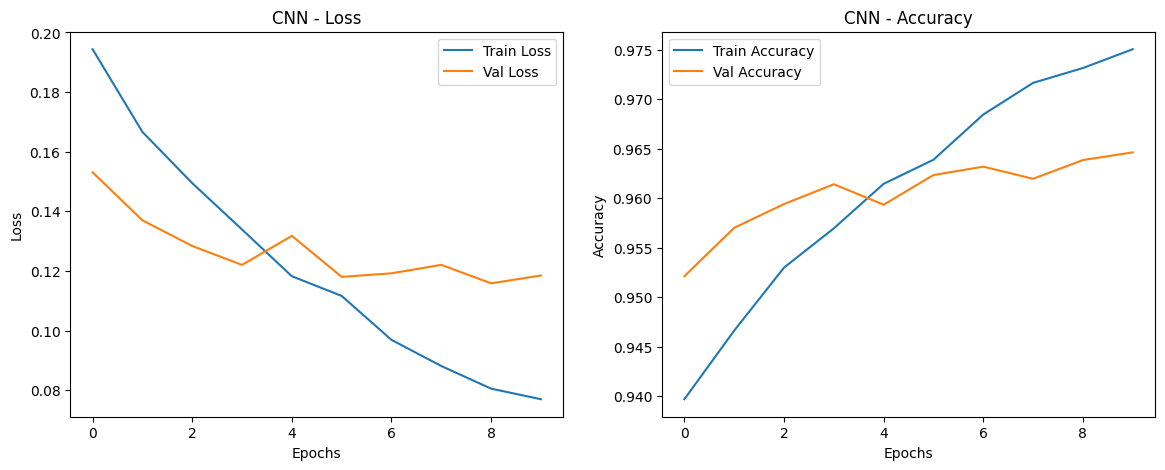

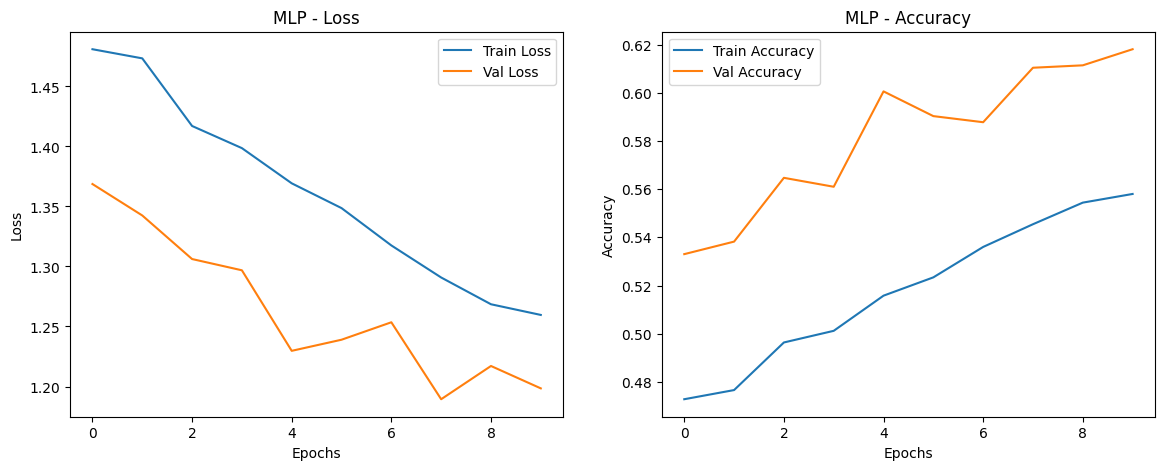

In [12]:
plot_model_history(cnn_history, 'CNN')
plot_model_history(mlp_history, 'MLP')

In [14]:
cnn_history_big = cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=128, verbose=2)
mlp_history_big = mlp_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=128, verbose=2)


Epoch 1/20
2344/2344 - 47s - 20ms/step - accuracy: 0.9749 - loss: 0.0793 - val_accuracy: 0.9807 - val_loss: 0.0616
Epoch 2/20
2344/2344 - 46s - 19ms/step - accuracy: 0.9777 - loss: 0.0697 - val_accuracy: 0.9819 - val_loss: 0.0590
Epoch 3/20
2344/2344 - 44s - 19ms/step - accuracy: 0.9803 - loss: 0.0613 - val_accuracy: 0.9804 - val_loss: 0.0645
Epoch 4/20
2344/2344 - 45s - 19ms/step - accuracy: 0.9820 - loss: 0.0556 - val_accuracy: 0.9826 - val_loss: 0.0589
Epoch 5/20
2344/2344 - 46s - 19ms/step - accuracy: 0.9835 - loss: 0.0504 - val_accuracy: 0.9828 - val_loss: 0.0635
Epoch 6/20
2344/2344 - 48s - 20ms/step - accuracy: 0.9845 - loss: 0.0466 - val_accuracy: 0.9823 - val_loss: 0.0655
Epoch 7/20
2344/2344 - 44s - 19ms/step - accuracy: 0.9851 - loss: 0.0440 - val_accuracy: 0.9821 - val_loss: 0.0681
Epoch 8/20
2344/2344 - 42s - 18ms/step - accuracy: 0.9857 - loss: 0.0424 - val_accuracy: 0.9837 - val_loss: 0.0602
Epoch 9/20
2344/2344 - 44s - 19ms/step - accuracy: 0.9869 - loss: 0.0388 - val_a

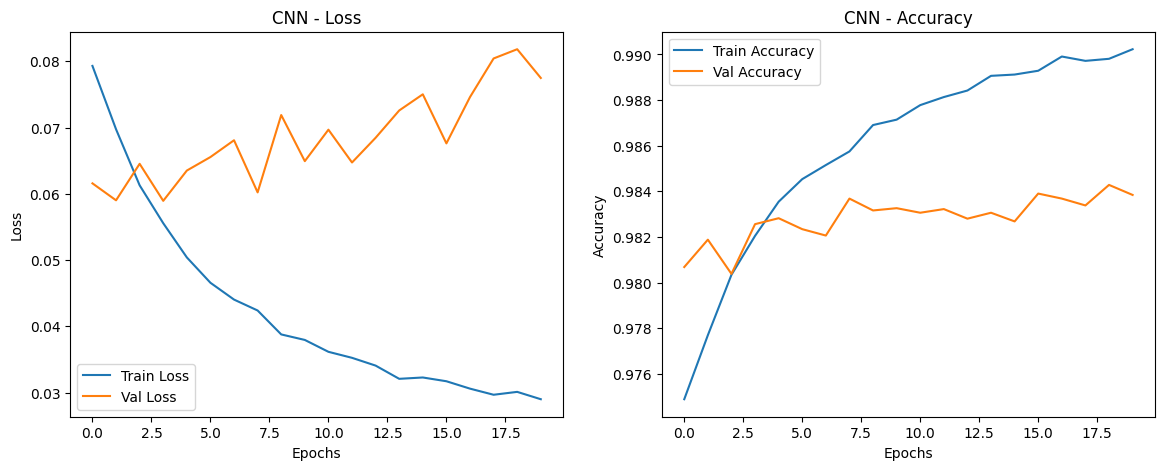

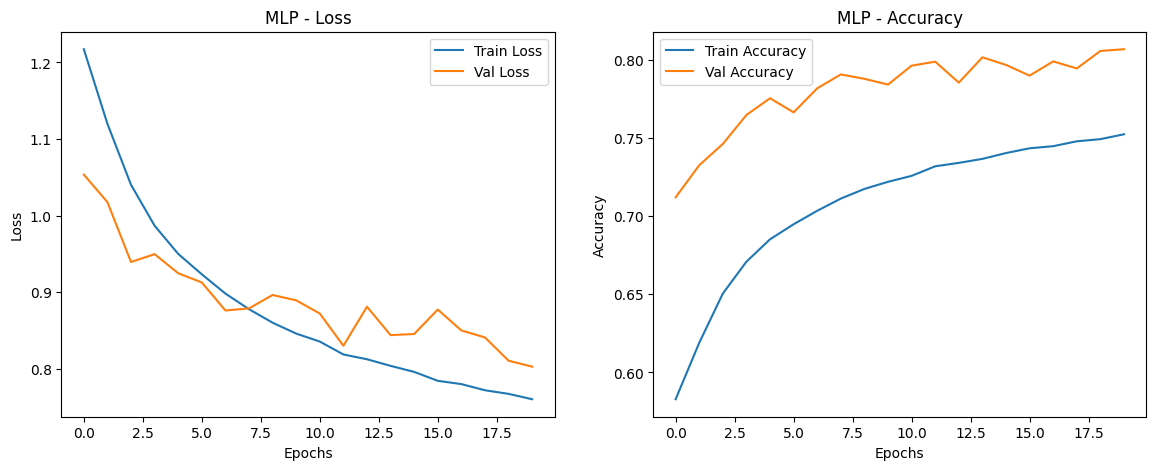

In [15]:
plot_model_history(cnn_history_big, 'CNN')
plot_model_history(mlp_history_big, 'MLP')